1816
OK


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

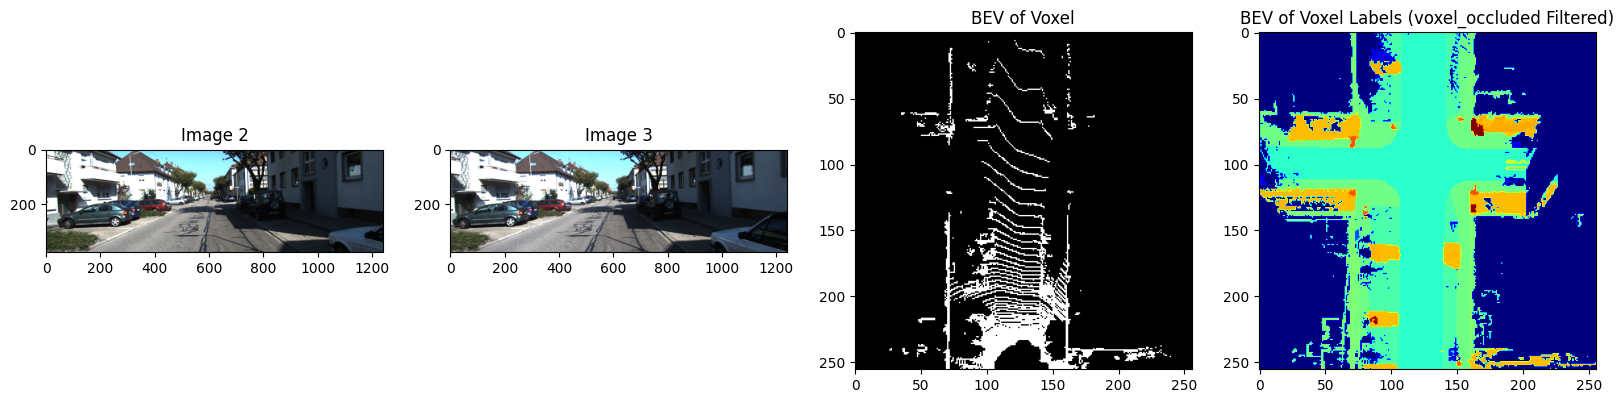

In [1]:
import torch
torch.cuda.is_available()
KITTI_DIR =  "/workspace/Dataset/dataset"

import sys
sys.path.insert(0, "/workspace/HKU-OccNet")

from dataset.loader import SemanticKITTIDatasetLite
import matplotlib.pyplot as plt
import random
import numpy as np
from torch.utils.data import DataLoader

# 假设已经import上面的SemanticKITTIDataset类的定义
# 创建数据集实例
dataset = SemanticKITTIDatasetLite(root_dir=KITTI_DIR, mode='train', sequences=['00'], downsample=2)

dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
print(len(dataloader))
for i, (image2, image3, voxel_labels ) in enumerate(dataloader):
                                                                print('OK');break

idx = random.randint(0,len(dataset))
dataset.plot(0)
idx, len(dataset), 

a,b,c = dataset[0]
c.shape


from dataset.utils import voxel_to_coordinates, visualize_voxels

# # 可视化预测结果
visualize_voxels(c.numpy().astype(np.uint8), key='mapped_lite',size=0.6)


In [2]:
import torch
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
device = 'cuda'

import torch
from torch import nn
import torch.nn.functional as F

class SemanticVoxelNetLite(nn.Module):
    def __init__(self, dinov2_model):
        super(SemanticVoxelNetLite, self).__init__()
        self.dino = dinov2_model

        # 冻结DINOv2模型的权重
        for param in self.dino.parameters():
            param.requires_grad = False

        # 2D卷积层，用于处理合并后的特征
        self.conv2d = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # 3D卷积层，用于从2D特征转换到3D体素
        self.conv3d = nn.Sequential(
            nn.Conv3d(256, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv3d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv3d(32, 10, kernel_size=3, padding=1)  # 9个分类
        )

    def forward(self, image1, image2):
        # 提取两个图像的特征
        features1 = self.dino.forward_features(image1)['x_norm_patchtokens']
        features2 = self.dino.forward_features(image2)['x_norm_patchtokens']

        # 重塑特征以匹配期望的体素空间
        batch_size = features1.size(0)
        features1 = features1.view(batch_size, -1, 27, 89)
        features2 = features2.view(batch_size, -1, 27, 89)

        # 结合来自两个图像的特征
        combined_features = torch.cat((features1, features2), dim=1)

        # 使用2D卷积层处理合并后的特征
        voxel_features = self.conv2d(combined_features)

        # 对特征进行上采样以匹配目标体素的空间尺寸
        voxel_features = F.interpolate(voxel_features, size=(128, 128), mode='bilinear')

        # 增加深度维度，并转换为3D体素
        voxel_features = voxel_features.unsqueeze(2)  # 增加深度维度
        voxel_features = F.interpolate(voxel_features, size=(16, 128, 128), mode='trilinear')

        # 应用3D卷积层进行分类
        voxel_output = self.conv3d(voxel_features)

        return voxel_output

In [ ]:
dinov2_vits14.to(device)
model = SemanticVoxelNetLite(dinov2_vits14).to(device)

from torchsummary import summary
summary(model,[(3,1246, 378),(3,1246, 378)])

In [5]:
import torch
import torch.nn as nn
torch. set_printoptions (threshold=np.inf)
class SemanticVoxelNetLiteLoss(nn.Module):
    def __init__(self):
        super(SemanticVoxelNetLiteLoss, self).__init__()
        self.cel = nn.CrossEntropyLoss(reduction='none')  # Set reduction to 'none' to handle it manually

        self.distance_mask = torch.zeros((128, 128, 16), dtype=torch.float)
        self.distance_mask[int(0.6 * 128):, :, :] = True
        self.distance_mask = self.distance_mask.reshape(-1).to(device)
        
        #print(self.distance_mask.shape)
    def forward(self, inputs, targets):
        """
        Compute the CE loss only for non-zero voxels.
        
        Args:
            inputs: Predicted voxel data. e.g., shape (-1, X, 128, 128, 16) with value (0,1) for multi-semantic X classes
            targets: Ground truth voxel data. e.g., shape (-1, 128, 128, 16) with value (0, X) for multi-semantic X classes
                Here we only calculate loss for targets != 0, since 0 is unknown
        Returns:
            Loss value computed only on non-zero voxels.
        """
        # Ensure the input is in the correct shape for CrossEntropyLoss
        #print("before inputs:", inputs.shape, "targets:", targets.shape) torch.Size([2, 10, 128, 128, 16]) targets: torch.Size([2, 128, 128, 16])
        # Inputs should be (N, C, H*W*D), and targets should be (N, H*W*D)
        N, C, H, W, D = inputs.shape
        #print(targets.shape)
        inputs_reshaped = inputs.reshape(N, C, -1)  # Now has shape (N, C, H*W*D)
        targets_reshaped = targets.reshape(N, -1)   # Now has shape (N, H*W*D)
        #print("after inputs:", inputs_reshaped.shape, "targets:", targets_reshaped.shape) torch.Size([2, 10, 262144]) targets: torch.Size([2, 262144])

        # Compute CE loss for all voxels
        all_losses = self.cel(inputs_reshaped, targets_reshaped)

        # Create a mask for non-zero target voxels
        #print(targets_reshaped.shape, self.distance_mask.shape)
        mask_near_nonzero = (targets_reshaped != 0) & (self.distance_mask != 0)

        # near_zone_mask = 
        
        # print(mask_zero.shape)


        # Apply mask to ignore voxels with label 0 in the loss computation
        masked_losses_near_nonzero = all_losses[mask_near_nonzero]
        # masked_losses = all_losses[mask]
        # masked_losses_zero = all_losses[mask_zero]

        # Average the loss over non-zero target voxels only
        loss = torch.mean(masked_losses_near_nonzero) + torch.mean(all_losses)*0.2
        
        return loss

# Example usage:
# loss_module = SemanticVoxelNetLiteLoss()
# loss = loss_module(inputs, targets)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# 假设 SemanticKITTIDataset, SemanticVoxelNet, ModifiedDinoV2 已经定义

# 定义损失函数和优化器
criterion = SemanticVoxelNetLiteLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

from torch.utils.data import DataLoader
# 初始化数据集和数据加载器
train_dataset = SemanticKITTIDatasetLite(root_dir=KITTI_DIR, mode='train', sequences=['00'], ratio=0.8)  # 填入适当的参数
val_dataset = SemanticKITTIDatasetLite(root_dir=KITTI_DIR, mode='test', sequences=['00'])    # 针对验证集
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# 训练参数
num_epochs = 2
best_loss = np.inf

# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    #初始化 tqdm 进度条
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch {epoch+1}')
    for batch in progress_bar:
        image1, image2, voxel_labels = batch
        image1, image2, voxel_labels = image1.to(device), image2.to(device), voxel_labels.to(device)
        #voxel_labels = voxel_labels.to(device)  # 假设 voxel_labels 已经是适当的格式
        #(-1, 9, 128, 128, 16)
        #print(image1.shape)

        optimizer.zero_grad()
        #voxel_labels (-1, 128, 128, 16)
        #print(voxel_labels.shape)

        # 计算输出
        voxel_output = model(image1, image2).permute(0,1,3,4,2)

        # 这里需要确保 voxel_output 和 voxel_labels 的形状一致
        # 以及它们的格式适用于所使用的损失函数
        loss = criterion(voxel_output, voxel_labels)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        progress_bar.set_description(f'Epoch {epoch+1} - Loss: {loss.item():.4f}')

    # 验证循环
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            image1, image2, voxel_labels = batch
            image1, image2, voxel_labels = image1.to(device), image2.to(device), voxel_labels.to(device)

            voxel_output = model(image1, image2).permute(0,1,3,4,2)
            # 同样需要确保输出和标签的格式适用于损失函数
            loss = criterion(voxel_output, voxel_labels)
            valid_loss += loss.item()
    
    #打印和保存最佳模型
    train_loss /= len(train_dataloader)
    valid_loss /= len(val_dataloader)
    print(f'Epoch {epoch + 1}: Training loss: {train_loss}, Validation loss: {valid_loss}')
    if train_loss < best_loss:
        torch.save(model.state_dict(), 'semantic_voxel_lite.pth')
        best_loss = train_loss


100%|██████████| 455/455 [02:38<00:00,  2.86it/s]


Epoch 1: Training loss: 0.50432730459563, Validation loss: 0.43078422916459513


100%|██████████| 455/455 [02:39<00:00,  2.85it/s]


Epoch 2: Training loss: 0.3350001513416415, Validation loss: 0.41295964763714715


In [7]:
torch.save(model, 'semantic_voxel_lite.pt')
model= torch.load('semantic_voxel_lite.pt',map_location=torch.device(device))  # 加载模型


In [8]:
model.eval()

# 获取验证集中的第一个样本
image1, image2, voxel_labels = val_dataset[200]
image1, image2 = image1.unsqueeze(0).to(device), image2.unsqueeze(0).to(device)  # 添加批次维度并移动到设备

# 获取模型预测
with torch.no_grad():
    voxel_output = model(image1, image2)
    # 可能需要转换 voxel_output 以适应可视化函数的输入格式
    print(voxel_output.shape)

torch.Size([1, 10, 16, 128, 128])


In [ ]:
# 转换 voxel_output 为适合可视化的格式

# 应用 softmax 获取概率分布
probabilities = F.softmax(voxel_output, dim=1)
print(probabilities.shape)

# 选择概率最大的类别索引
voxel_pred = torch.argmax(probabilities, dim=1)
print(voxel_pred)
print(np.unique(voxel_pred.squeeze().cpu().numpy()))
# # 将输出转换为 [256, 256, 32]
voxel_pred = voxel_pred.permute(0,2,3,1).squeeze().cpu().numpy().astype(np.uint8)
voxel_pred.shape

In [10]:
import numpy as np
import yaml
import imageio
from PIL import Image
import bqplot.scales
import ipyvolume as ipv
labels_lite = ['unlabeled', 'vehicle', 'two-wheeler', 'person', 'road', 'sidewalk', 'building', 'natural', 'manmade', 'empty']

def visualize_voxels(voxel_data, key = 'voxel_labels',size = None, marker = None):

        max_idx = {
            'voxel_invalid':1,
            'voxel_occluded':1,
            'voxel':1,
            'mapped_label':21,
            'mapped_lite':10,
        }
            
        x, y, z, tags = voxel_to_coordinates(voxel_data, voxel_size = 1 / voxel_data.shape[0], threshold = -1 if key in ['voxel_invalid','voxel_occluded'] else 0)

        # 创建颜色比例尺
        color_scale = bqplot.scales.ColorScale(min=0, max=9, colors=['#FFFAFA','#FFDEAD','#7FFFD4','#54FF9F','#7B68EE','#1E90FF','#ADD8E6','#40E0D0','#EEE685','#FFC1C1','#F0FFF0'])

        fig = ipv.figure()

        # 确定tags中的唯一值
        unique_tags = np.unique(tags)

        # 为每个唯一的tag值创建一个scatter
        for tag in unique_tags:
            # 过滤出当前tag的坐标
            mask = tags == tag
            x_filtered, y_filtered, z_filtered, tags_f = x[mask], y[mask], z[mask], tags[mask]
            # 创建scatter
            if key=='voxel_labels':
                ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.2, description="{}, len({})={}".format(labels[tag],str(tag),x_filtered.shape[0]))
            elif key=='mapped_label':
                ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.2, description="{}, len({})={}".format(labels[learning_map_inv[tag]],str(tag),x_filtered.shape[0]))
            elif key=='mapped_lite':
                ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.5, description="{}, count={}".format(labels_lite[tag],x_filtered.shape[0]))
            else:
                ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.2, description="len({})={}".format(str(tag),x_filtered.shape[0]))
        #ipv.scatter(1-y,x, z, color=tags, color_scale=color_scale, marker=marker or 'box', size=size or 0.1)
        ipv.xyzlabel('y','x','z')
        ipv.view(0, -90, distance=2.5)
        ipv.show()


In [11]:

from dataset.utils import voxel_to_coordinates

# 可视化预测结果
visualize_voxels(voxel_pred, key='mapped_lite', size=0.8, marker='sphere')


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

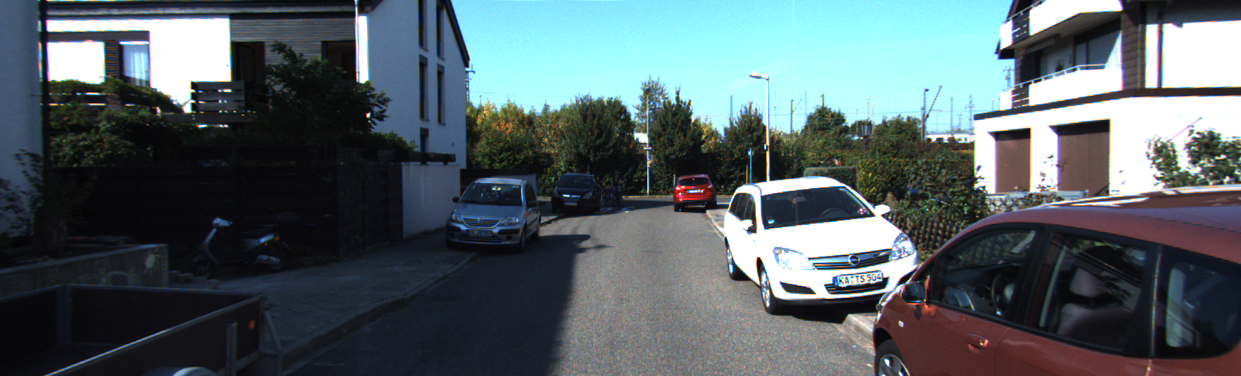

In [12]:
val_dataset.get_dict(200)['image2']

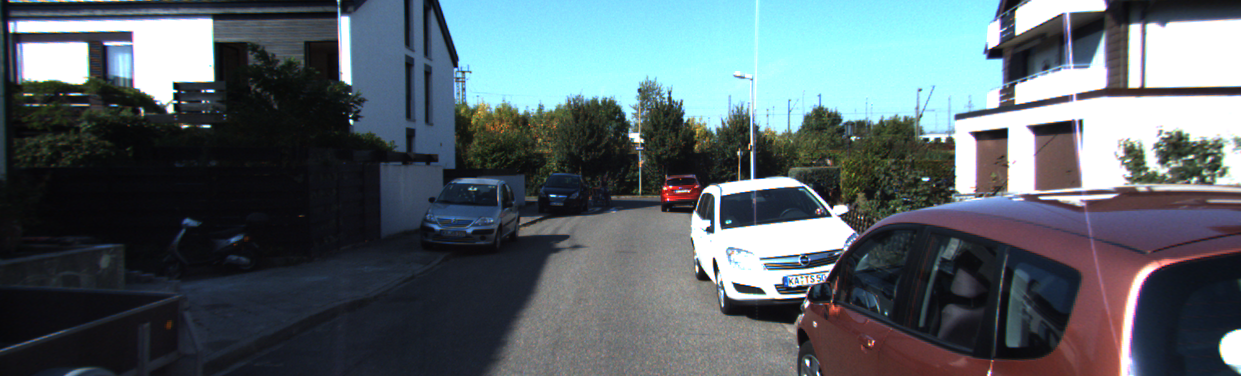

In [13]:
val_dataset.get_dict(200)['image3']